# Train decoder

## Dataset loading

### Import libraries

In [1]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os

os.chdir("/home/ubuntu/")

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

Load the dataset with hugging face and split between train and test.

In [2]:
ds = load_dataset('json', data_files='/home/ubuntu/data/intestinal_organoid_dataset/one_mask_metadata.json')

test_dataset = ds["train"].filter(lambda example: example["split"] == "test")
del(ds)

Define the local folder where the dataset is located.

In [3]:
# Define dataset location folder
data_folder = "/home/ubuntu/data/intestinal_organoid_dataset/"

Define the processor (encoder) of SAM.

In [4]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Adapt the actual dataset for SAM.

In [5]:
from utils.sam_dataset import SAMDataset
sam_test_dataset = SAMDataset(dataset=test_dataset, processor=processor, data_folder=data_folder)
del(test_dataset)

In [6]:
item = sam_test_dataset[0]
print("Keys in item:", item.keys())  # Add this line to print the keys

Keys in item: dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'input_points', 'ground_truth_mask', 'original_image', 'gt_box'])


### Create PyTorch dataloader

In [7]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(sam_test_dataset, batch_size=1, shuffle=True)

In [8]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)
del(k, v)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
input_points torch.Size([1, 1, 1, 2])
ground_truth_mask torch.Size([1, 450, 450])
original_image torch.Size([1, 450, 450, 3])


/home/ubuntu/venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


AttributeError: 'list' object has no attribute 'shape'

## Train SAM

### Load the model

Make sure we only compute gradients for the mask decoder

In [9]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

See first mask prediction.

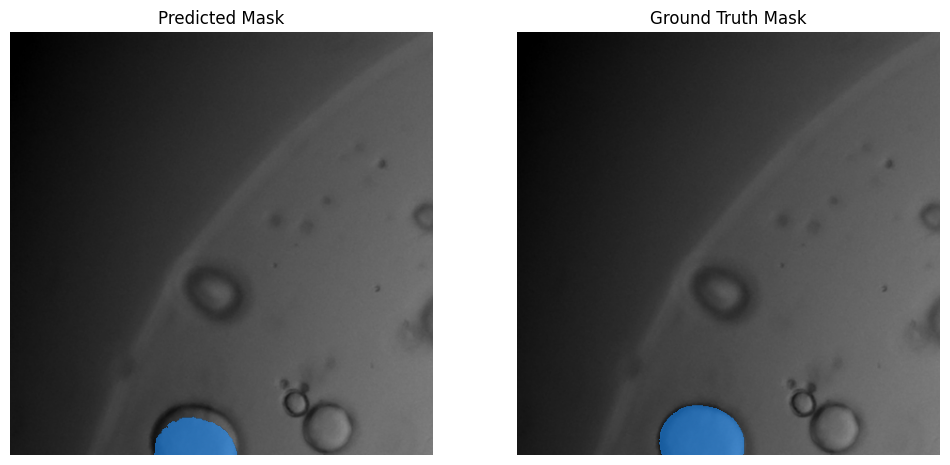

In [10]:
from utils.inference_sam import show_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Compute mask
outputs = model(pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False)
# Post-process mask
predicted_masks = outputs.pred_masks.to(device)
predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                mode="bilinear", align_corners=False)
predicted_masks = predicted_masks[..., :992, :1024]
predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                mode="bilinear", align_corners=False)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Predicted Mask
axes[0].imshow(np.array(batch["original_image"]).squeeze())
# apply sigmoid
mask_seg_prob = torch.sigmoid(predicted_masks)
# convert soft mask to hard mask
mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
first_mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
show_mask(first_mask_seg, axes[0])
axes[0].set_title("Predicted Mask")
axes[0].axis("off")

# Plot Ground Truth Mask
ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
axes[1].imshow(np.array(batch["original_image"]).squeeze())
show_mask(ground_truth_masks, axes[1])
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

plt.show()

### Train the model

In [14]:
from torch.optim import Adam
import monai
from utils.model_training import train_model


# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=1e-4)
# Define geometrical loss
geom_loss = monai.losses.DiceCELoss(sigmoid=False, squared_pred=True, reduction='mean')
# Define number of epochs
num_epochs = 100
# Define parameters for topological loss
topo_param = {'lamda': 0.1, 
              'interp': 50, 
              'feat_d': 1, 
              'loss_q': 2, 
              'loss_r': False}

In [15]:
# Run training function
train_model(model, prompt = "box", optimizer = optimizer, geometric_loss = geom_loss, train_dataloader = test_dataloader, val_dataloader = test_dataloader, patience = 0,
            num_epochs = num_epochs, device = "cuda", geom_interp = 150, topological_loss = True, topo_param = topo_param)

EPOCH: 1


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Train dataset mean loss: 0.8305746912956238


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Validation dataset mean loss: 0.8255282640457153
EPOCH: 2


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Train dataset mean loss: 0.8284091949462891


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Validation dataset mean loss: 0.8984034061431885
EPOCH: 3


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Train dataset mean loss: 0.8268972039222717


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8172042369842529
EPOCH: 4


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Train dataset mean loss: 0.8252876996994019


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Validation dataset mean loss: 0.8427496552467346
EPOCH: 5


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8714366555213928


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.8162680864334106
EPOCH: 6


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8112211227416992


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Validation dataset mean loss: 0.921734094619751
EPOCH: 7


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.9138658046722412


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.8238565921783447
EPOCH: 8


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Train dataset mean loss: 0.8144310116767883


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Validation dataset mean loss: 0.8966314196586609
EPOCH: 9


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.817719578742981


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.8206632137298584
EPOCH: 10


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Train dataset mean loss: 0.8125472068786621


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8098241090774536
EPOCH: 11


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Train dataset mean loss: 0.8172637224197388


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Validation dataset mean loss: 0.8355157971382141
EPOCH: 12


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Train dataset mean loss: 0.8242758512496948


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8021508455276489
EPOCH: 13


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Train dataset mean loss: 0.9001756310462952


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8105480670928955
EPOCH: 14


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8031848669052124


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.805622935295105
EPOCH: 15


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Train dataset mean loss: 0.8084302544593811


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8111431002616882
EPOCH: 16


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8099496364593506


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.8075423836708069
EPOCH: 17


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8095431923866272


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.8056557774543762
EPOCH: 18


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8034113645553589


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.7910056710243225
EPOCH: 19


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.7967426180839539


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8132296800613403
EPOCH: 20


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8106558918952942


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Validation dataset mean loss: 0.8050026893615723
EPOCH: 21


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8094854950904846


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8048984408378601
EPOCH: 22


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Train dataset mean loss: 0.7658914923667908


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7853586077690125
EPOCH: 23


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.7621440291404724


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.7651665806770325
EPOCH: 24


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7953078746795654


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Validation dataset mean loss: 0.7930382490158081
EPOCH: 25


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.7969960570335388


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8362060785293579
EPOCH: 26


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7928492426872253


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.862800657749176
EPOCH: 27


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Train dataset mean loss: 1.0491325855255127


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.9596588015556335
EPOCH: 28


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8143758773803711


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.8037720322608948
EPOCH: 29


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Train dataset mean loss: 0.8116136193275452


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.7977719306945801
EPOCH: 30


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Train dataset mean loss: 0.902112603187561


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Validation dataset mean loss: 0.7748868465423584
EPOCH: 31


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Train dataset mean loss: 0.7873761653900146


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.799305260181427
EPOCH: 32


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Train dataset mean loss: 0.7831583619117737


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8121100068092346
EPOCH: 33


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Train dataset mean loss: 0.7777560949325562


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.7516340017318726
EPOCH: 34


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Train dataset mean loss: 0.7704036831855774


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Validation dataset mean loss: 0.7842310667037964
EPOCH: 35


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.7823542952537537


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.7961729764938354
EPOCH: 36


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train dataset mean loss: 0.8038127422332764


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.7350665330886841
EPOCH: 37


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8129187226295471


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation dataset mean loss: 0.7974783182144165
EPOCH: 38


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Train dataset mean loss: 0.8021522164344788


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8229791522026062
EPOCH: 39


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.8022041320800781


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.7925233840942383
EPOCH: 40


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Train dataset mean loss: 0.80503249168396


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8184114694595337
EPOCH: 41


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train dataset mean loss: 0.8040162324905396


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7571330070495605
EPOCH: 42


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Train dataset mean loss: 0.8036587238311768


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.7934389114379883
EPOCH: 43


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.789137601852417


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8082699179649353
EPOCH: 44


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Train dataset mean loss: 0.8137730956077576


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.797292947769165
EPOCH: 45


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train dataset mean loss: 0.7499662041664124


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.7929509878158569
EPOCH: 46


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.7824844121932983


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation dataset mean loss: 0.8024742603302002
EPOCH: 47


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7991434335708618


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7936660647392273
EPOCH: 48


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Train dataset mean loss: 0.7764101624488831


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.790195882320404
EPOCH: 49


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7700234055519104


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation dataset mean loss: 0.8043389320373535
EPOCH: 50


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Train dataset mean loss: 0.790520191192627


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.8077470660209656
EPOCH: 51


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.8160955905914307


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7616875171661377
EPOCH: 52


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Train dataset mean loss: 0.7690920233726501


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Validation dataset mean loss: 0.7335845828056335
EPOCH: 53


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7635353803634644


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.7955582141876221
EPOCH: 54


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train dataset mean loss: 0.7627421617507935


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation dataset mean loss: 0.7567989230155945
EPOCH: 55


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train dataset mean loss: 0.8000061511993408


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7582653760910034
EPOCH: 56


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Train dataset mean loss: 0.7376980185508728


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation dataset mean loss: 0.7550972104072571
EPOCH: 57


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7609654068946838


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7968559861183167
EPOCH: 58


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Train dataset mean loss: 0.7520456314086914


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation dataset mean loss: 0.7450037598609924
EPOCH: 59


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7643812894821167


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.7406054139137268
EPOCH: 60


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train dataset mean loss: 0.7453007102012634


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.7635284662246704
EPOCH: 61


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Train dataset mean loss: 0.7618159651756287


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.7650799751281738
EPOCH: 62


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7642877697944641


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Validation dataset mean loss: 0.7763540148735046
EPOCH: 63


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7514819502830505


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.7339917421340942
EPOCH: 64


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7367751002311707


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Validation dataset mean loss: 0.7456614971160889
EPOCH: 65


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7800121903419495


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7413453459739685
EPOCH: 66


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Train dataset mean loss: 0.7384431958198547


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.7273030877113342
EPOCH: 67


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7468963265419006


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.7214728593826294
EPOCH: 68


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Train dataset mean loss: 0.7734031081199646


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation dataset mean loss: 0.7338875532150269
EPOCH: 69


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7536495923995972


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.7701799273490906
EPOCH: 70


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7351236343383789


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation dataset mean loss: 0.7969896197319031
EPOCH: 71


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Train dataset mean loss: 0.7650418877601624


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Validation dataset mean loss: 0.7787795066833496
EPOCH: 72


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7521250247955322


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Validation dataset mean loss: 0.7277898192405701
EPOCH: 73


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Train dataset mean loss: 0.7546358108520508


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.7657391428947449
EPOCH: 74


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7251190543174744


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.746303379535675
EPOCH: 75


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7464785575866699


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation dataset mean loss: 0.7924650311470032
EPOCH: 76


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7321447730064392


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.7153918147087097
EPOCH: 77


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7338897585868835


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Validation dataset mean loss: 0.7417347431182861
EPOCH: 78


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train dataset mean loss: 0.7823516130447388


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Validation dataset mean loss: 0.76598060131073
EPOCH: 79


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7348242402076721


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Validation dataset mean loss: 0.7330375909805298
EPOCH: 80


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.726818323135376


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.7489515542984009
EPOCH: 81


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7388035655021667


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7211447954177856
EPOCH: 82


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7266637086868286


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Validation dataset mean loss: 0.7357175946235657
EPOCH: 83


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7165330648422241


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Validation dataset mean loss: 0.7159952521324158
EPOCH: 84


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7893840074539185


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Validation dataset mean loss: 0.7229940295219421
EPOCH: 85


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7604002356529236


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.7153965830802917
EPOCH: 86


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Train dataset mean loss: 0.7321184277534485


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation dataset mean loss: 0.7857030034065247
EPOCH: 87


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7212591171264648


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Validation dataset mean loss: 0.7262318730354309
EPOCH: 88


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.719179630279541


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation dataset mean loss: 0.7617302536964417
EPOCH: 89


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Train dataset mean loss: 0.7303241491317749


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.7385249137878418
EPOCH: 90


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7231335043907166


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.7157639265060425
EPOCH: 91


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train dataset mean loss: 0.7316122055053711


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Validation dataset mean loss: 0.7088481187820435
EPOCH: 92


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7193333506584167


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.7157914042472839
EPOCH: 93


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7210326790809631


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.7268821597099304
EPOCH: 94


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7158964276313782


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Validation dataset mean loss: 0.7373051643371582
EPOCH: 95


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7652173638343811


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Validation dataset mean loss: 0.7134909629821777
EPOCH: 96


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.738743007183075


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7264397740364075
EPOCH: 97


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Train dataset mean loss: 0.7476015686988831


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Validation dataset mean loss: 0.7084661722183228
EPOCH: 98


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7116376757621765


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation dataset mean loss: 0.7087833881378174
EPOCH: 99


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train dataset mean loss: 0.7118831276893616


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Validation dataset mean loss: 0.7352651357650757
EPOCH: 100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Train dataset mean loss: 0.7228139638900757


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Validation dataset mean loss: 0.7328165173530579


See now the results.

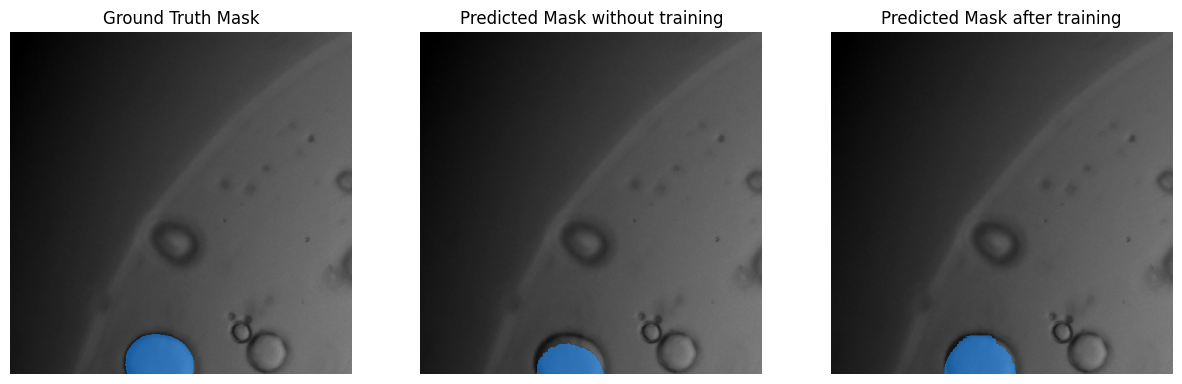

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Compute mask
outputs = model(pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False)
# Post-process mask
predicted_masks = outputs.pred_masks.to(device)
predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                mode="bilinear", align_corners=False)
predicted_masks = predicted_masks[..., :992, :1024]
predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                mode="bilinear", align_corners=False)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Ground Truth Mask
ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
axes[0].imshow(np.array(batch["original_image"]).squeeze())
show_mask(ground_truth_masks, axes[0])
axes[0].set_title("Ground Truth Mask")
axes[0].axis("off")

# Plot initial predicted mask
axes[1].imshow(np.array(batch["original_image"]).squeeze())
show_mask(first_mask_seg, axes[1])
axes[1].set_title("Predicted Mask without training")
axes[1].axis("off")

# Plot predicted mask after training
axes[2].imshow(np.array(batch["original_image"]).squeeze())
# apply sigmoid
mask_seg_prob = torch.sigmoid(predicted_masks)
# convert soft mask to hard mask
mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
show_mask(mask_seg, axes[2])
axes[2].set_title("Predicted Mask after training")
axes[2].axis("off")

plt.show()